# 1. Chargement et exploration des donn√©es

## T√©l√©chargement des datasets depuis Kaggle

In [1]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
from dotenv import load_dotenv
import pandas as pd


def download_dataset(dataset_name, destination_dir="../data"):
    try:
        if not os.path.exists(destination_dir):
            os.makedirs(destination_dir)

        api.dataset_download_files(dataset_name, path=destination_dir, unzip=True)

    except Exception as e:
        print(f"Erreur lors du t√©l√©chargement : {e}")

load_dotenv()
os.environ['KAGGLE_USERNAME'] = os.getenv('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = os.getenv('KAGGLE_KEY')

api = KaggleApi()

try:
    api.authenticate()    
except Exception as e:
    print(f"Erreur d'authentification : {e}")

try:
    download_dataset("sumanthvrao/daily-climate-time-series-data")
except Exception as e:
    print(f"Erreur lors du t√©l√©chargement du dataset : {e}")

train_path = "../data/DailyDelhiClimateTrain.csv"
test_path = "../data/DailyDelhiClimateTest.csv"

try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
except FileNotFoundError as e:
    print(f"Erreur lors du chargement des fichiers : {e}")


Dataset URL: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data


Deux fichiers CSV ont √©t√© cr√©√©s dans le dossier `data/` :

- `DailyDelhiClimateTest.csv`
- `DailyDelhiClimateTrain.csv`

Les deux fichiers poss√®dent les m√™mes propri√©t√©s ; la seule diff√©rence r√©side dans leur taille. Le fichier `DailyDelhiClimateTrain.csv` est destin√© √† l'entra√Ænement complet du mod√®le, tandis que le fichier `DailyDelhiClimateTest.csv`, plus r√©duit, servira a test√© le mod√®le. Il y aura aussi une √©tape de validation les donn√©es utilis√©es pour cette √©tape seront reprises (20%) du dataset d'entra√Ænement lors du pr√©traitement des donn√©es

### Apercu des fichiers

In [4]:
print("Aper√ßu fichier entrainement")
display(train_df.head())

print("Aper√ßu fichier de test")
display(test_df.head())

Aper√ßu fichier entrainement


date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000

Aper√ßu fichier de test


date   meantemp   humidity  wind_speed  meanpressure
0  2017-01-01  15.913043  85.869565    2.743478     59.000000
1  2017-01-02  18.500000  77.222222    2.894444   1018.277778
2  2017-01-03  17.111111  81.888889    4.016667   1018.333333
3  2017-01-04  18.700000  70.050000    4.545000   1015.700000
4  2017-01-05  18.388889  74.944444    3.300000   1014.333333

Nous nous int√©resserons ici seulement √† la colonne `meantemp`, qui repr√©sente la temp√©rature moyenne.

Nous remarquons que les deux fichiers suivent le m√™me format.

Nous remarquons aussi que le fichier de test n'est que la suite logique du fichier d'entra√Ænement :  
le fichier d'entra√Ænement se termine le 1er janvier 2017 et le fichier de test commence le m√™me jour.

## Exploration des donn√©es

### Simplification des datasets

Afin de simplifier l'exploration des donn√©es, et √©tant donn√© que les deux fichiers sont successifs et suivent le m√™me format, nous allons cr√©er un dataset unique en pla√ßant le dataset de test √† la suite du dataset d'entra√Ænement.

Nous remarquons un premier probl√®me : la derni√®re ligne du fichier d'entra√Ænement, dat√©e du 01/01/2017, n'est pas identique √† la premi√®re ligne du fichier de test, √©galement dat√©e du 01/01/2017.


- Fin du fichier d'entrainement

In [22]:
print(train_df[["date", "meantemp"]].tail())

           date   meantemp
1457 2016-12-28  17.217391
1458 2016-12-29  15.238095
1459 2016-12-30  14.095238
1460 2016-12-31  15.052632
1461 2017-01-01  10.000000


- D√©but du fichier de test

In [20]:
print(test_df[["date", "meantemp"]].head())

         date   meantemp
0  2017-01-01  15.913043
1  2017-01-02  18.500000
2  2017-01-03  17.111111
3  2017-01-04  18.700000
4  2017-01-05  18.388889


On se rend vite compte que la ligne incorrecte est la derni√®re du dataset d'entra√Ænement, avec une valeur parfaitement ronde qui n'a pas de sens si l'on regarde les temp√©ratures pr√©c√©dentes et suivantes.

Nous pouvons donc maintenant :

- Supprimer la derni√®re ligne du fichier d'entra√Ænement ;
- Cr√©er un dataset global contenant la succession des deux datasets et l'enregistrer.

1. Suppression de la derniere ligne du fichier d'entrainement

In [24]:
df = pd.read_csv(train_path)

df = df[:-1]

df.to_csv(train_path, index=False)

2. Creer un dataset global

In [3]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

global_df = pd.concat([train_df, test_df], ignore_index=True)

global_df.to_csv("../data/GlobalDataSet.csv", index=False)

### Valeurs manquantes

Voyons maintenant si des valeurs sont manquantes dans la colonne qui nous interesse : `meantemp`

In [30]:
isAnyValueMissing = global_df["meantemp"].isnull().any()

if isAnyValueMissing:
    print("Il y a au moins une valeur manquante")
else:
    print("La colonne ne contient aucune valeur manquante")

La colonne ne contient aucune valeur manquante


Nous remarquons donc aucune valeur manquante.

### Valeurs ab√©rrantes

Voyons si des valeurs ab√©rrantes se trouvent dans les fichiers commen√ßons par analyser le minimum/maximum

#### Min/Max

In [31]:
print(global_df["meantemp"].describe())

count    1575.000000
mean       25.231582
std         7.337316
min         6.000000
25%        18.516667
50%        27.166667
75%        31.142857
max        38.714286
Name: meantemp, dtype: float64


Les temp√©ratures varient entre `6¬∞C` et `38.71¬∞C`. Ces valeurs sont totalement plausible

#### Saut de valeur trop important

Il est aussi int√©ressant de v√©rifier s‚Äôil n'existe pas des sauts de valeur aberrants, comme par exemple un passage de `0¬∞C` √† `30¬∞C` en une seule journ√©e.

Commen√ßons par analyser le saut le plus important.


In [32]:
diffs = global_df["meantemp"].diff().abs()
print("Max saut observ√© :", diffs.max())

Max saut observ√© : 10.625


On remarque dans le dataset un saut de `10¬∞C` d‚Äôun jour √† l‚Äôautre, ce qui semble important, bien que possible. Nous allons donc essayer d‚Äôexaminer cela de plus pr√®s.

Commen√ßons par analyser combien de fois ce type de saut se produit.  
Prenons dans un premier temps un seuil de `7¬∞C`.

In [ ]:
seuil = 7

diffs = global_df["meantemp"].diff().abs()

nombre_sauts = (diffs > seuil).sum()

print(f"Nombre de sauts sup√©rieurs √† {seuil}¬∞C : {nombre_sauts}")

Nombre de sauts sup√©rieurs √† 7¬∞C : 2


Nous avons identifi√© deux valeurs pr√©sentant un saut important.  
C‚Äôest bon signe, car m√™me s‚Äôil y a une ou deux erreurs, celles-ci n‚Äôaffecteront pas significativement notre mod√®le.

Par curiosit√©, nous allons tout de m√™me nous renseigner sur ces deux sauts.

Commen√ßons par identifier les dates de ces deux sauts :


In [41]:
saut_indices = diffs[diffs > seuil].index

dates_sauts = global_df.loc[saut_indices, "date"]

for i in saut_indices:
    date = global_df.loc[i, "date"]
    valeur_saut = diffs.loc[i]
    print(f"{date} ‚Üí saut de {valeur_saut:.2f}¬∞C")

2015-06-25 ‚Üí saut de 10.62¬∞C
2015-07-06 ‚Üí saut de 7.84¬∞C


Bien que les sauts de temp√©rature observ√©s √† New Delhi les 25 juin (+10,62¬∞C) et 6 juillet 2015 (+7,84¬∞C) soient impressionnants.

- L'√©cart de 7.84¬∞ semble bien r√©el
- L‚Äô√©cart du 25 juin est probablement surestim√© avec une valeur r√©elle plus proche de 6‚Äì7¬∞C
- Ce saut pourrait √™tre d√ª √† une mauvaise pond√©ration de la moyenne journali√®re ou √† des donn√©es influenc√©es par des conditions m√©t√©orologiques ponctuelles (il y avait de la pluie et certains disent un orage)).
- New Delhi √©tant une tr√®s grande m√©tropole (plus de 1 400 km¬≤ les diff√©rences de temp√©rature entre quartiers ainsi que l‚Äôorigine exacte des mesures peuvent jouer un r√¥le important dans l‚Äôinterpr√©tation de ces donn√©es.

Sources :
- [Time and Date ‚Äì Historique m√©t√©o juin 2015 √† New Delhi](https://www.timeanddate.com/weather/india/new-delhi/historic?month=6&year=2015)
- [Weather Underground ‚Äì Historique quotidien 24 juin 2015](https://www.wunderground.com/history/weekly/in/new-delhi/VIDP/date/2015-6-24)

Nous ne modifierons pas la donn√©e, m√™me si elle semble peu probable, car son **impact reste tr√®s limit√©**.

### Fr√©quence des donn√©es

In [42]:
global_df["date"] = pd.to_datetime(global_df["date"])

diffs = global_df["date"].diff()

print(diffs.value_counts())

date
1 days    1574
Name: count, dtype: int64


On remarque que la fr√©quence des donn√©es est constante, avec un intervalle d‚Äôun jour entre chaque enregistrement.
Cela signifie que le jeu de donn√©es est √† **fr√©quence quotidienne**.

### Tendance

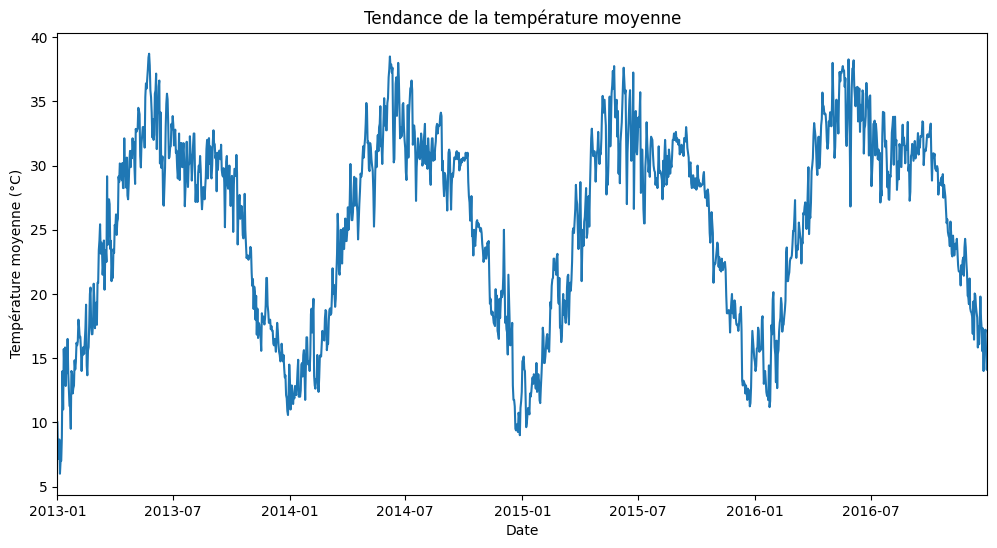

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Tracer
plt.figure(figsize=(12, 6))
plt.plot(global_df["date"], global_df["meantemp"])
plt.title("Tendance de la temp√©rature moyenne")
plt.xlabel("Date")
plt.ylabel("Temp√©rature moyenne (¬∞C)")
plt.xlim(global_df["date"].min(), global_df["date"].max()) 
plt.show()


Le graphique de la temp√©rature moyenne journali√®re met en √©vidence un cycle claire, avec une hausse progressive des temp√©ratures au printemps, un pic en √©t√©, suivi d‚Äôune baisse en automne et en hiver, qui se r√©p√®te chaque ann√©e.

### Saisonalit√©

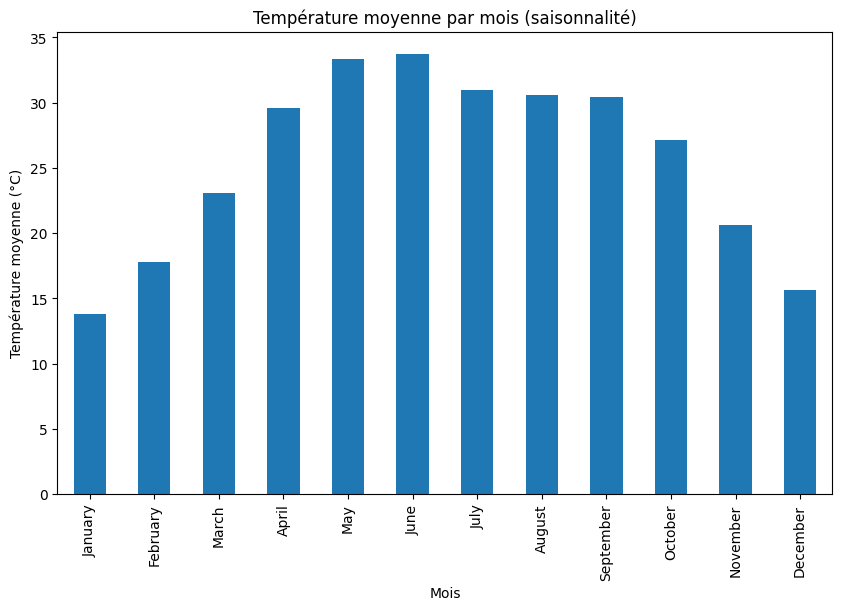

In [4]:
import matplotlib.pyplot as plt

import calendar

global_df["date"] = pd.to_datetime(global_df["date"])

global_df["month"] = global_df["date"].dt.month
monthly_avg = global_df.groupby("month")["meantemp"].mean()


plt.figure(figsize=(10, 6)) 

monthly_avg.plot(kind="bar")

plt.xticks(ticks=range(12), labels=[calendar.month_name[i+1] for i in range(12)])

plt.title("Temp√©rature moyenne par mois (saisonnalit√©)")
plt.xlabel("Mois")
plt.ylabel("Temp√©rature moyenne (¬∞C)")
plt.show()

Les temp√©ratures sont les plus basses en hiver (janvier, d√©cembre), augmentent progressivement au printemps, atteignent un maximum en mai-juin, puis redescendent vers l‚Äôautomne et l‚Äôhiver.

**Notebook suivant : Pr√©traitement des donn√©es**

üëâ [Aller au Notebook suivant](02_pretraitement_des_donnees.ipynb)
